# Homework 5: Transfer Learning with MobileNetV2 on the Intel Image Dataset

## Due: Midnight on October 5th (with 2-hour grace period) and worth 85 points

In this assignment you’ll take a modern pretrained CNN (MobileNetV2) and use it to classify the **Intel Image** dataset (6 scene classes). You’ll start with the network as a **frozen feature extractor**, then progressively **fine-tune** it in different ways. The goal is to understand *why* transfer learning works, how to design a good **classification head**, and how choices like **learning rate**, **LR schedules**, and **which layers to unfreeze** affect accuracy.

### Learning Objectives

* Understand the difference between **feature extraction** (frozen backbone) and **fine-tuning** (unfrozen).
* How to design and compare **heads** on top of a pretrained backbone.
* Practical training knobs: **LR schedules** (fixed / exponential / cosine), **ReduceLROnPlateau**, **EarlyStopping**, **Dropout/L2**, and **BatchNorm** in heads.
* Fine-tuning strategies: unfreezing the **whole model**, the **top N layers**, or the **top K conv blocks**.


### Baseline model (starting point)

* `MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  → backbone outputs a **1280-D** vector per image (already globally averaged).
* Minimal head: a **single Dense softmax** for 6 classes.
* **Do not** add another pooling layer when `pooling="avg"` is set.

### The five problems (high level)

For each of problems 1 - 4, you will perform 3 experiments, reflect on what you observed, and report the validation accuracy of your best model. 

1. **Problem 1 — Frozen backbone:** Redesign the **head** only (backbone stays frozen). Try ≥3 head variants and basic training knobs.
2. **Problem 2 — Unfreeze all:** Start from your best head and fine-tune the **entire** network with a **small LR**.
3. **Problem 3 — Unfreeze top N layers:** Keep most layers frozen; unfreeze only the **last N** and fine-tune.
4. **Problem 4 — Unfreeze top K blocks:** Unfreeze the **last K MobileNetV2 stages** (e.g., `block_16`, `Conv_1`, etc.) and fine-tune.
5. **Problem 5 — Final Reflection Question**

Use your HW4 CNN results as a reference point. Your aim is to **match or beat** that baseline with transfer learning, and to understand *why* your best choices worked.


## 1. Setup and Data Loading


In [3]:
import os

# GPU는 쓰되 XLA 완전 차단 (거대 fused kernel 방지)
os.environ["TF_XLA_FLAGS"] = "--tf_xla_auto_jit=0 --tf_xla_enable_xla_devices=false"
os.environ["XLA_FLAGS"] = "--xla_gpu_enable_triton_gemm=false"  # 일부 긴 GEMM 방지

# 길게 버티는 알고리즘 탐색/비결정 동작도 막기(안정성 우선)
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"  # CPU 경로 최적화가 GPU 쪽과 섞일 때의 드문 이슈 회피

# (선택) 스레드/메모리 과열 완화
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
os.environ["TF_NUM_INTEROP_THREADS"] = "2"
os.environ["MALLOC_ARENA_MAX"] = "2"


In [4]:
# -------- Standard library --------
import os
import time
import random
from collections import Counter

# Quiet TensorFlow logs (set BEFORE importing TF)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# -------- Third-party --------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import kagglehub

import tensorflow as tf
from tensorflow.keras import layers,models, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Input,
    MaxPooling2D,
    ReLU,
    SeparableConv2D,
)

from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import load_img, img_to_array



he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

# Reproducibility settings
# -------------------------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))


tf.config.optimizer.set_jit(False)


/home/abcbbong/miniforge3/envs/vevn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import tensorflow as tf
tf.config.optimizer.set_jit(False)                 # 그래프 레벨 JIT도 명시적으로 OFF
tf.keras.mixed_precision.set_global_policy("float32")  # 혼합정밀 꺼서 커널 길이/복잡도 축소


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [6]:

def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        # print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}\t{ep}")

###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables

In [7]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 100,                   # Just needs to be bigger than early stopping point
                   lr_schedule   = 1e-3,                  # Adam default 
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 128,                  
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"],
                  jit_compile=False)

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),      
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the Intel Image Classification Dataset  

In [8]:
path      = kagglehub.dataset_download("puneet6060/intel-image-classification")
train_dir = os.path.join(path, "seg_train/seg_train")
test_dir  = os.path.join(path, "seg_test/seg_test")

In [9]:
# Reproducible load + preprocess for Intel Image Classification

IMG_SHAPE = (224,224,3)
IMG_SIZE = IMG_SHAPE[:2]

# -------------------------
# Loader (deterministic)
# -------------------------

def load_data_from_directory(directory, img_size=IMG_SIZE, class_names=None, preprocess="mobilenet_v2"):
    """
    Loads images as float32 and integer labels.
    If preprocess == 'mobilenet_v2', outputs are scaled to [-1, 1] as expected by MobileNetV2.
    Else, outputs are scaled to [0,1].
    """
    if class_names is None:
        class_names = sorted(
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
        )
    else:
        class_names = [c for c in class_names if os.path.isdir(os.path.join(directory, c))]

    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    X, y = [], []
    for class_name in class_names:
        folder = os.path.join(directory, class_name)
        for fname in sorted(os.listdir(folder)):
            if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
                continue
            img_path = os.path.join(folder, fname)
            img = load_img(img_path, target_size=img_size, interpolation="bilinear")
            arr = img_to_array(img).astype("float32")  # values in [0,255]
            if preprocess == "mobilenet_v2":
                # Official Keras preprocessing: scales to [-1, 1]
                arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
            else:
                arr = arr / 255.0  # your original behavior
            X.append(arr)
            y.append(class_to_idx[class_name])

    X = np.stack(X).astype("float32")
    y = np.array(y, dtype="int32")
    return X, y, class_names


In [10]:
# Load full training set (preprocessed for MobileNetV2)
X_all, y_all, class_names = load_data_from_directory(
    train_dir, img_size=IMG_SIZE , preprocess="mobilenet_v2"
)

# 80/20 stratified split -> train / val
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.20,
    stratify=y_all,
    random_state=random_seed,
    shuffle=True,
)

# Load test set using same class mapping + preprocessing
X_test, y_test, _ = load_data_from_directory(
    test_dir, 
    img_size=IMG_SIZE, 
    class_names=class_names
)

num_classes = len(class_names)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)

print(f'num_classes: {num_classes}')
print('Class Names:', class_names)

Train: (11227, 224, 224, 3) (11227,)
Val:   (2807, 224, 224, 3) (2807,)
Test:  (3000, 224, 224, 3) (3000,)
num_classes: 6
Class Names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


### Examine The Dataset

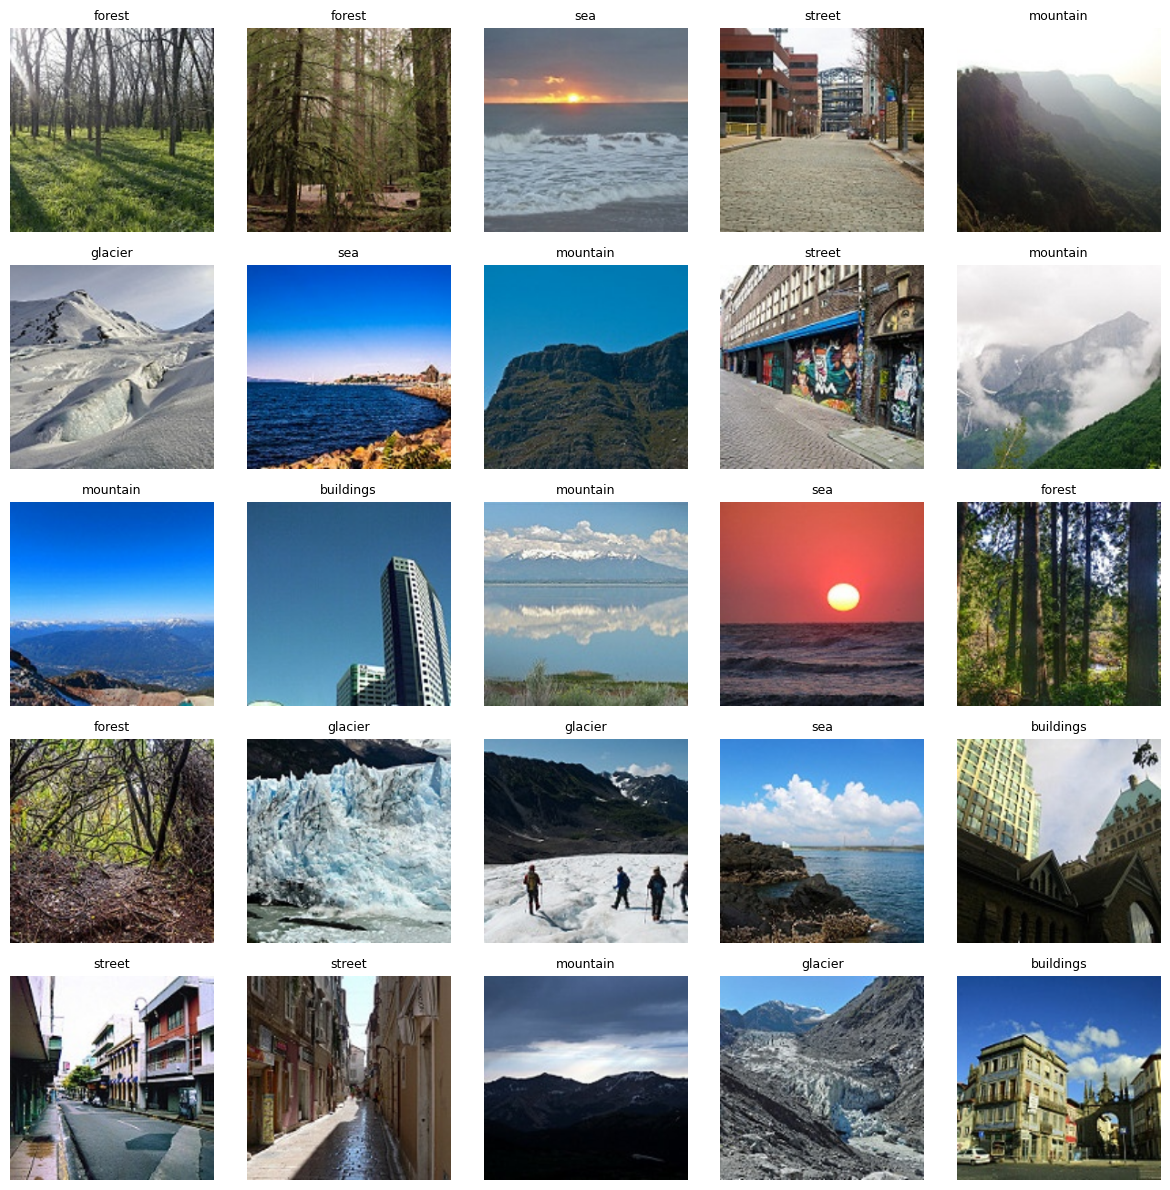

In [11]:
# pick 25 random, distinct indices
idx = np.random.choice(len(X_train), size=25, replace=False)

plt.figure(figsize=(12, 12))
for k, i in enumerate(idx, start=1):
    ax = plt.subplot(5, 5, k)
    ax.imshow((X_train[i] + 1.0) / 2.0)
    # if y_train is one-hot, take argmax; otherwise use the label directly
    label_idx = int(np.argmax(y_train[i])) if getattr(y_train, "ndim", 1) > 1 else int(y_train[i])
    plt.title(class_names[label_idx], fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()



### Learning Rate Schedulers

In [12]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

In [13]:
# Both these must be input as lr_schedule in train_and_test(....   , lr_schedule=exp_decay, .... )

epochs = 100               # You'll need to adjust this to close to be close to the early stopping location
batch_size = 64

# Needed by LR schedulers

steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

exp_decay = ExponentialDecay(
    initial_learning_rate=0.0001,  #  the starting learning rate (before any decay)
    decay_steps=total_steps,     #  how many training steps (batches) before applying decay
    decay_rate=0.98,              #  multiplicative factor of decay (new_lr = lr * decay_rate^(step/decay_steps))
    staircase=False,             #  if True, decay in discrete intervals (floor(step/decay_steps)),
                                 #  if False, decay smoothly each step
)

cosine_decay = CosineDecay(
    initial_learning_rate=0.0001, #  the starting learning rate
    decay_steps=total_steps,      #  number of training steps (batches) over which to decay
    alpha=0.0,                    #  minimum learning rate value as a fraction of initial_learning_rate
                                  #  (final_lr = initial_lr * alpha)
)

### Prelude: Baseline Model

`MobileNetV2` is a lightweight, ImageNet-pretrained CNN that produces efficient, high-quality visual features.

See the **Appendix** for further information on `MobileNetV2`. 

The baseline model defined in the next cell is essentially a frozen **feature extractor** that outputs a 1280-D vector (after built-in **Global Average Pooling**).



In [14]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

def make_base_model_pooled(trainable=False):
    base = mobilenet_v2.MobileNetV2(
        weights='imagenet', include_top=False,
        input_shape=IMG_SHAPE, pooling='avg'
    )
    base.trainable = trainable
    return base
    
base = make_base_model_pooled()

print("Some statistics on the model:")
print("Total Keras layers:", len(base.layers))

# Count unique inverted-residual blocks by their prefix 'block_<n>'
block_ids = sorted({int(l.name.split('_')[1])
                    for l in base.layers if l.name.startswith('block_')})
print("Conv Block IDs:", block_ids, " (count:", len(block_ids), ")")

# Check if the final Conv_1 stage exists
has_conv1 = any(l.name.startswith('Conv_1') for l in base.layers)
print("Has Conv_1 stage:", has_conv1)
print('Model Output Shape:',base.output_shape)

I0000 00:00:1759352144.711973  130971 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Some statistics on the model:
Total Keras layers: 155
Conv Block IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]  (count: 16 )
Has Conv_1 stage: True
Model Output Shape: (None, 1280)


In [15]:
# Ha, this is very long!

# base.summary()


Model Baseline



2025-10-01 13:55:57.732521: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 13:56:09.725223: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

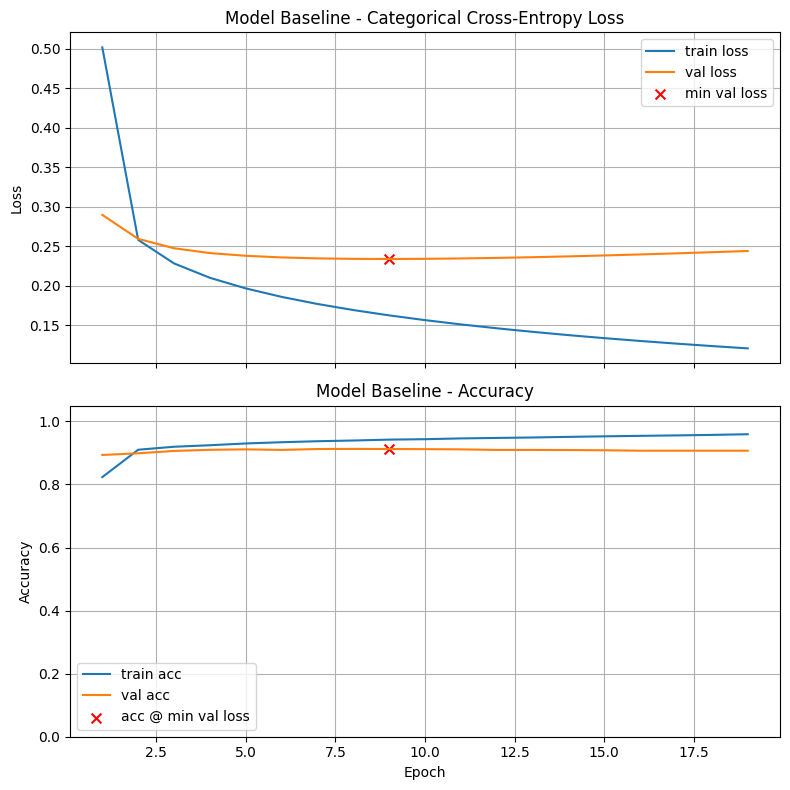

Final Training Loss:            0.1204
Final Training Accuracy:        0.9593
Final Validation Loss:          0.2438
Final Validation Accuracy:      0.9070
Validation Accuracy @ Min Loss: 0.9124


2025-10-01 13:58:25.330498: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2163
Test Accuracy: 0.9200

Validation-Test Gap (accuracy): 0.007638

Execution Time: 00:02:40


In [16]:
# ALWAYS construct a new instance, to avoid sharing layers in multiple models

base_model = make_base_model_pooled()               # default: trainable=False

model_baseline = models.Sequential([
    base_model,
    Dense(num_classes, activation='softmax')  
])

train_and_test(model_baseline, title="Model Baseline")

## Problem 1 — Frozen MobileNetV2 (Feature Extractor): Redesign the Head

**Goal.** Keep the MobileNetV2 backbone **frozen** and boost accuracy by modifying **only the classification head**.

**Setup.**

```python
base = make_base_pooled()  # default: trainable=False
```


### To Do:

1. **Ask an AI helper** (e.g., ChatGPT):
   *“What are some more complex heads that could improve this model on the Intel Image Classification Dataset, **without** unfreezing the backbone?”*
2. **Implement at least three** different head designs (they can be AI-suggested or inspired by HW4).
3. **Tune hyperparameters** for each experiment, such as:

   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** settings
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (may be combined with a fixed LR)
4. **Train and compare** the three heads and **give each experiment a unique descriptive title,** i.e., `title="Problem 1 Experiment 1"`
5. **Answer the graded questions.**

### Notes / Constraints

* The descriptive title will be used to compare results at the end of the notebook. 
* With `pooling="avg"`, This backbone already applies Global Average Pooling and outputs a **1280-D** feature vector per image. **Do not** add `GlobalAveragePooling2D()` again.
* Using BatchNorm inside the head is fine; **do not** place BN immediately before the final softmax layer.


Warming up the baseline model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step

Problem 1 -- Baseline Head Fixed LR



2025-10-01 13:58:45.618807: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 13:59:00.642821: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

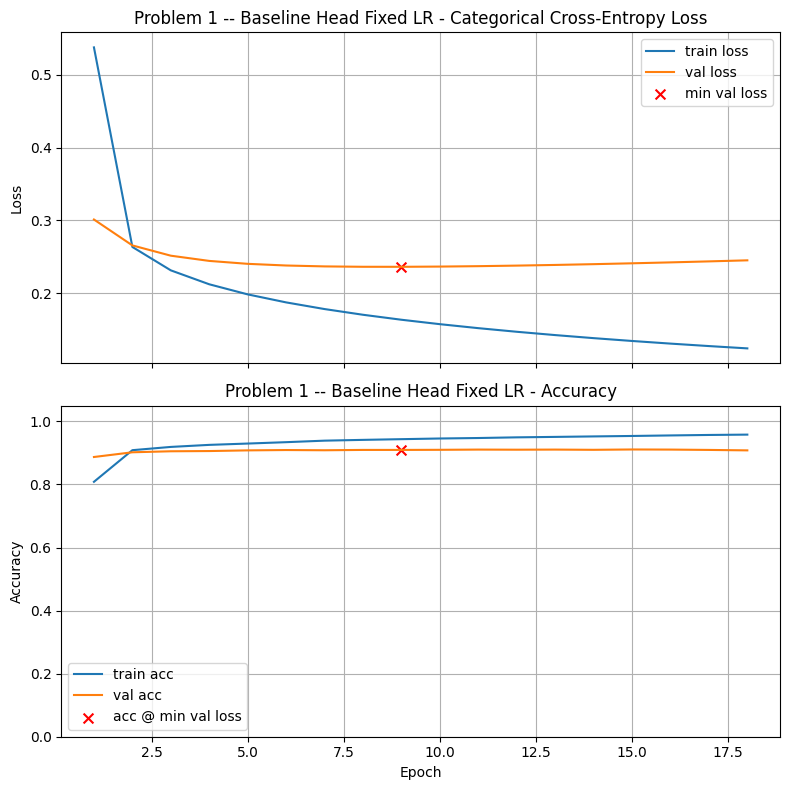

Final Training Loss:            0.1242
Final Training Accuracy:        0.9580
Final Validation Loss:          0.2452
Final Validation Accuracy:      0.9081
Validation Accuracy @ Min Loss: 0.9095


2025-10-01 14:01:05.355362: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2174
Test Accuracy: 0.9173

Validation-Test Gap (accuracy): 0.007821

Execution Time: 00:02:39
Warming up the deeper head model with L2...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step

Problem 1 -- Deeper Head with L2 Exp Decay



2025-10-01 14:01:22.697996: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 14:01:32.891249: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

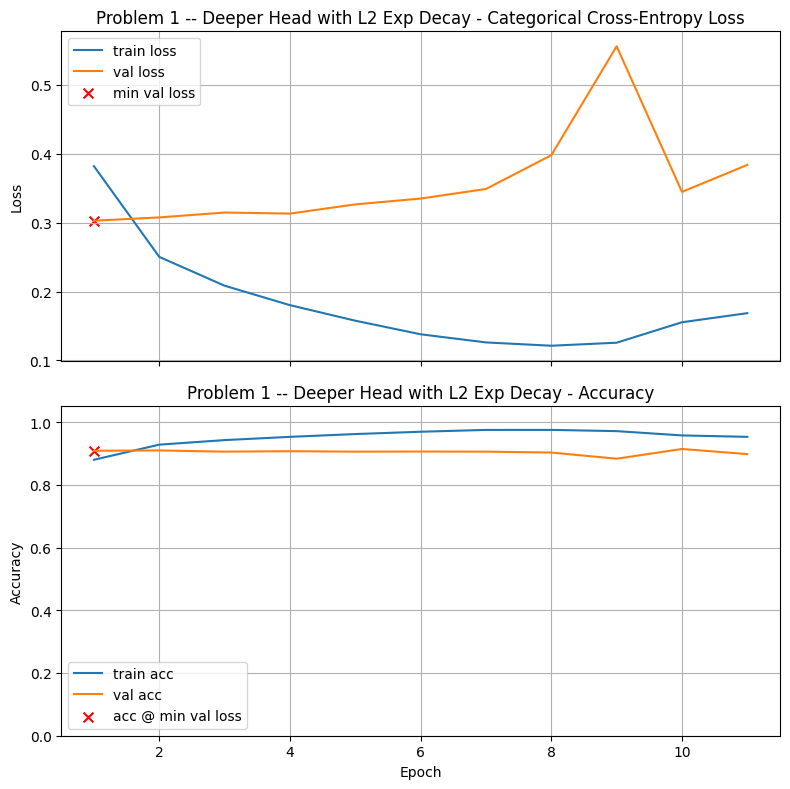

Final Training Loss:            0.1687
Final Training Accuracy:        0.9528
Final Validation Loss:          0.3838
Final Validation Accuracy:      0.8978
Validation Accuracy @ Min Loss: 0.9084


2025-10-01 14:02:49.465765: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2898
Test Accuracy: 0.9117

Validation-Test Gap (accuracy): 0.003224

Execution Time: 00:01:39
Warming up the deeper head model with Dropout and BatchNorm...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step

Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay



2025-10-01 14:03:05.444887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 14:03:16.032631: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

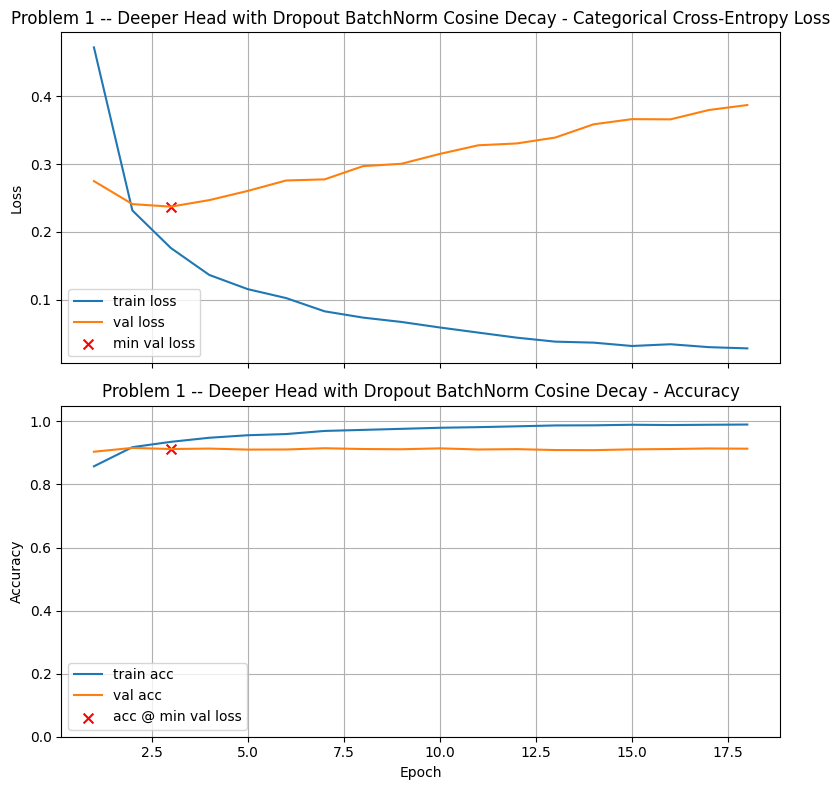

Final Training Loss:            0.0282
Final Training Accuracy:        0.9900
Final Validation Loss:          0.3874
Final Validation Accuracy:      0.9134
Validation Accuracy @ Min Loss: 0.9124


2025-10-01 14:05:24.315304: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2218
Test Accuracy: 0.9163

Validation-Test Gap (accuracy): 0.003971

Execution Time: 00:02:30
Model Baseline                          	0.9124	9
Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay	0.9124	3
Problem 1 -- Baseline Head Fixed LR     	0.9095	9
Problem 1 -- Deeper Head with L2 Exp Decay	0.9084	1


In [17]:
# Your code here; add as many cells as you need

from IPython.display import display

# 1. Results list remains the same
results_list_q1 = []

# Dynamic LR schedule setup from your code
epochs = 100
batch_size = 64
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

# --- Experiment 1-1: Baseline Head + Fixed LR (no schedule change) ---
model_baseline = models.Sequential([
    base_model,
    layers.Dense(num_classes, activation='softmax')
])
print("Warming up the baseline model...")
_ = model_baseline.predict(X_train[:32])

# train_and_test 함수가 알아서 차트를 그려줄 것이므로, history 객체만 받습니다.
history = train_and_test(model_baseline, lr_schedule=1e-3, title="Problem 1 -- Baseline Head Fixed LR", return_history=True)
# plot_learning_curves(history, "Problem 1 -- Baseline Head Fixed LR") # ✨ 이 부분을 주석 처리하여 중복 차트 방지

_, test_acc = model_baseline.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q1.append({"Model": "Problem 1 -- Baseline Head Fixed LR", "Val Acc": val_acc, "Test Acc": test_acc})

# --- Experiment 1-2: Deeper Head with L2 + Exponential Decay LR ---
lr_schedule_exp = ExponentialDecay(
    initial_learning_rate=1e-3, 
    decay_steps=total_steps,
    decay_rate=0.96, 
    staircase=False
)
model_deep_l2 = models.Sequential([
    base_model,
    layers.Dense(256, activation='relu', kernel_initializer=he, kernel_regularizer=l2reg),
    layers.Dense(num_classes, activation='softmax')
])
print("Warming up the deeper head model with L2...")
_ = model_deep_l2.predict(X_train[:32])

history = train_and_test(model_deep_l2, lr_schedule=lr_schedule_exp, title="Problem 1 -- Deeper Head with L2 Exp Decay", return_history=True)
# plot_learning_curves(history, "Problem 1 -- Deeper Head with L2 Exp Decay") # ✨ 이 부분을 주석 처리

_, test_acc = model_deep_l2.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q1.append({"Model": "Problem 1 -- Deeper Head with L2 Exp Decay", "Val Acc": val_acc, "Test Acc": test_acc})

# --- Experiment 1-3: Deeper Head with Dropout and BatchNorm + Cosine Decay LR ---
lr_schedule_cos = CosineDecay(
    initial_learning_rate=1e-3, 
    decay_steps=total_steps,
    alpha=0.0
)
model_dropout_bn = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_initializer=he),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])
print("Warming up the deeper head model with Dropout and BatchNorm...")
_ = model_dropout_bn.predict(X_train[:32])

history = train_and_test(model_dropout_bn, lr_schedule=lr_schedule_cos, title="Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay", 
                         patience=15, min_delta=0.001, return_history=True)
# plot_learning_curves(history, "Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay") # ✨ 이 부분을 주석 처리

_, test_acc = model_dropout_bn.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q1.append({"Model": "Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 전체 결과 요약 ---
# print_results() 함수가 이미 요약 테이블을 출력해주므로, display는 주석 처리합니다.
print_results()
# display(results_list_q1) # ✨ 이 부분을 주석 처리하여 중복 결과 테이블 방지

In [18]:
# =======================================================
# A1: 올바르게 수정된 최종 결과 분석
# =======================================================

# 1. 'Val Acc'(검증 정확도)를 기준으로 내림차순 정렬하여 최적 모델을 선택합니다.
results_df_q1 = pd.DataFrame(results_list_q1)
results_df_q1 = results_df_q1.set_index("Model")
results_df_q1_sorted = results_df_q1.sort_values(by="Val Acc", ascending=False)

print("\n\n===== Question 1: Head Design Comparison (Sorted by Validation Accuracy) =====")
display(results_df_q1_sorted)

# 2. 정렬된 DataFrame의 첫 번째 행이 바로 최적 모델입니다.
best_model_row = results_df_q1_sorted.iloc[0]

# 3. 이 최적 모델의 'Val Acc' 값을 a1 변수에 할당합니다.
a1 = best_model_row['Val Acc']

print(f"The best model (based on Validation Acc) is: '{best_model_row.name}'")
print(f"Its Validation Accuracy was: {a1:.4f}")
print(f"Assigning this value to a1...")
print(f"\na1 = {a1}")



===== Question 1: Head Design Comparison (Sorted by Validation Accuracy) =====


,Val Acc,Test Acc
Model,,
Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay,0.912362,0.916333
Problem 1 -- Baseline Head Fixed LR,0.909512,0.917333
Problem 1 -- Deeper Head with L2 Exp Decay,0.908443,0.911667


The best model (based on Validation Acc) is: 'Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay'
Its Validation Accuracy was: 0.9124
Assigning this value to a1...

a1 = 0.9123619794845581


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **frozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Identify the head architecture and experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is frozen.


**Your answer here:**

The **`Deeper Head with Dropout BatchNorm Cosine Decay`** architecture proved to be the most effective, achieving the highest validation accuracy of approximately **91.24%**. This model's success likely comes from its combination of a deeper structure for greater learning capacity, robust regularization from both `Dropout` and `BatchNormalization` to prevent overfitting, and an advanced `CosineDecay` learning rate schedule that optimized convergence. This result suggests that when the backbone is frozen, the head is not merely a simple classifier but must function as a capable and well-regularized mini-network to effectively process the fixed, high-level features and generalize to new data.



In [19]:
# Set a1 to the validation accuracy found by your best model for this problem. 

a1 = best_model_row['Val Acc']             # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem         

print(f'a1 = {a1}') 


a1 = 0.9123619794845581


## Problem Two — Fine-tuning the Whole MobileNetV2 (Unfrozen)

**Goal.** Start from your best head from Problem 1, **unfreeze the backbone**, and fine-tune the entire model.

**Setup.** Build the base as **trainable** (it already applies Global Average Pooling and outputs a 1280-D vector—don’t add another pooling layer):

```python
base = make_base_pooled(trainable=True)  # MobileNetV2(include_top=False, pooling="avg")
```

### To Do:

1. **Design at least three experiments** with the model **unfrozen**. Vary:

   * **Head choice** (pick one from Problem 1).
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**.
   * **EarlyStopping** parameters.
   * **Regularization:** Dropout and/or L2.
   * **ReduceLROnPlateau:** on vs. off (can combine with a fixed LR).
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 2 Experiment 1"`
3. **Answer the graded questions.**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook. 
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

--- Starting Experiment 2-1: Fixed Small LR ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step

Problem 2 -- Unfreeze All Fixed Small LR



2025-10-01 14:25:53.464206: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 14:26:32.182336: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

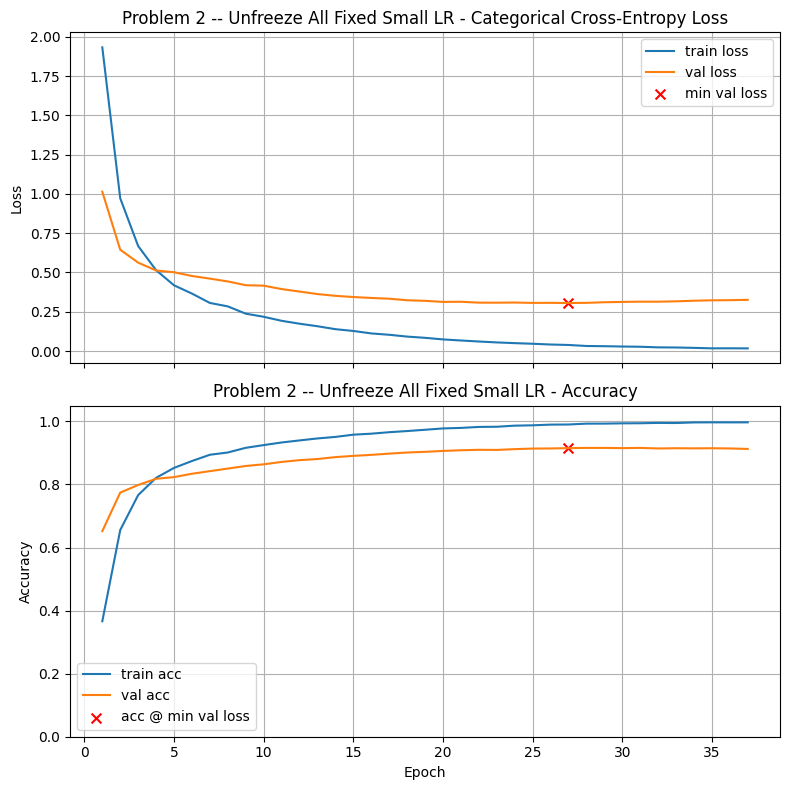

Final Training Loss:            0.0168
Final Training Accuracy:        0.9970
Final Validation Loss:          0.3257
Final Validation Accuracy:      0.9127
Validation Accuracy @ Min Loss: 0.9152


2025-10-01 14:40:42.921701: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2934
Test Accuracy: 0.9140

Validation-Test Gap (accuracy): 0.001212

Execution Time: 00:15:01

--- Starting Experiment 2-2: Exponential Decay Small LR ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step

Problem 2 -- Unfreeze All Exp Decay Small LR



2025-10-01 14:41:01.405441: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 14:41:38.699091: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

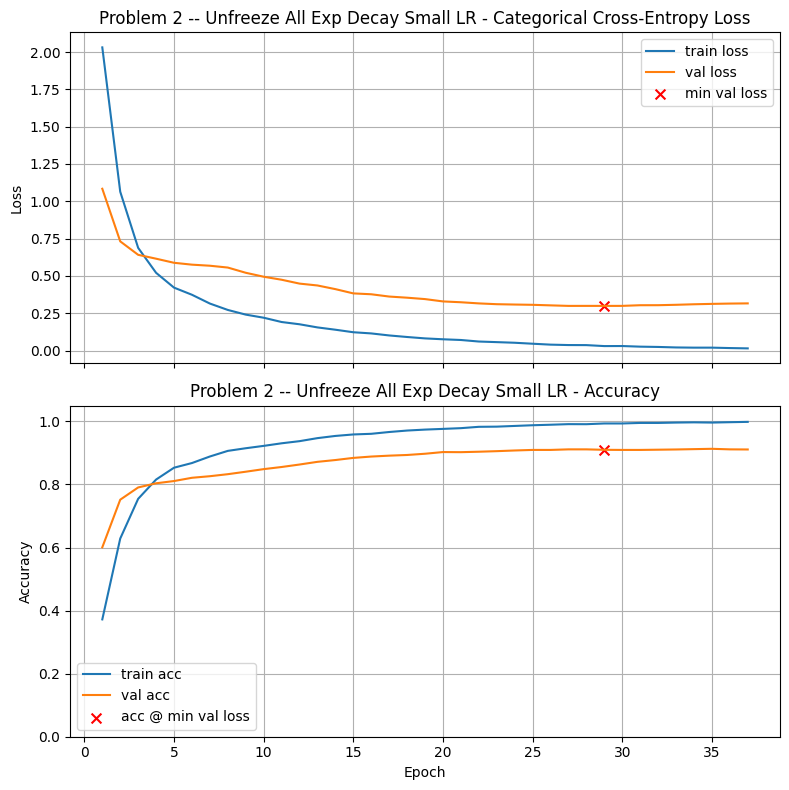

Final Training Loss:            0.0144
Final Training Accuracy:        0.9985
Final Validation Loss:          0.3159
Final Validation Accuracy:      0.9109
Validation Accuracy @ Min Loss: 0.9099


2025-10-01 14:55:43.977337: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.3072
Test Accuracy: 0.9127

Validation-Test Gap (accuracy): 0.001373

Execution Time: 00:14:56

--- Starting Experiment 2-3: Cosine Decay Small LR ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step

Problem 2 -- Unfreeze All Cosine Decay Small LR



2025-10-01 14:56:01.251714: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 14:56:39.253746: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

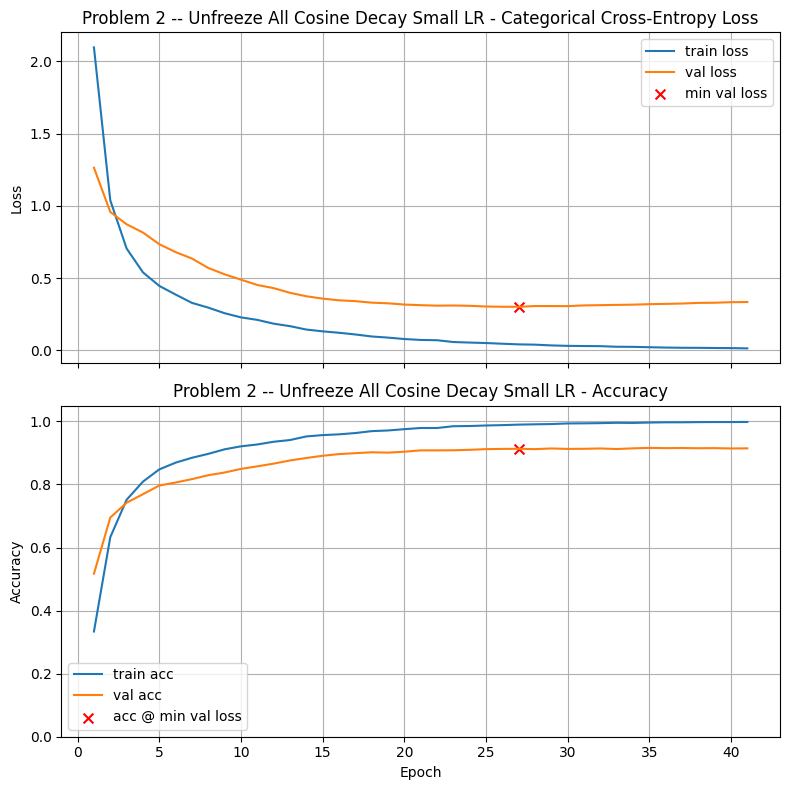

Final Training Loss:            0.0131
Final Training Accuracy:        0.9982
Final Validation Loss:          0.3340
Final Validation Accuracy:      0.9145
Validation Accuracy @ Min Loss: 0.9131


2025-10-01 15:12:12.954045: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.3098
Test Accuracy: 0.9057

Validation-Test Gap (accuracy): 0.007052

Execution Time: 00:16:23
Problem 2 -- Unfreeze All Fixed Small LR	0.9152	27
Problem 2 -- Unfreeze All Cosine Decay Small LR	0.9131	27
Model Baseline                          	0.9124	9
Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay	0.9124	3
Problem 2 -- Unfreeze All Exp Decay Small LR	0.9099	29
Problem 1 -- Baseline Head Fixed LR     	0.9095	9
Problem 1 -- Deeper Head with L2 Exp Decay	0.9084	1


In [21]:
# Your code here; add as many cells as you need
from tensorflow.keras import applications
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

# --- 사전 준비 ---
he = he_normal()

# 2번 실험 결과를 저장할 리스트
results_list_q2 = []

# --- ✨ 안정성을 위한 설정 (사용자 피드백 반영) ✨ ---
batch_size = 64 # 잘 작동한다고 하신 배치 사이즈 64로 설정
epochs = 100
steps_per_epoch = int(np.ceil(len(X_train) / batch_size))
total_steps = epochs * steps_per_epoch

# ===================================================================
# === ✨ Fine-tuning 모델 생성 함수 (1번 실험 결과 반영) ✨ ===
# ===================================================================
def build_finetune_model(input_shape, num_classes):
    """
    새로운 MobileNetV2 백본을 로드하고, 1번 실험의 최고 성능 Head를
    붙여 완전한 Fine-tuning 모델을 반환합니다.
    """
    base_model = applications.MobileNetV2(weights='imagenet',
                                          include_top=False,
                                          input_shape=input_shape)
    base_model.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(), # ValueError 방지
        # 1등 Head 구조 (Dropout + BatchNorm)
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_initializer=he),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- 실험 2-1: Best Head + Unfreeze All + 고정된 작은 LR ---
print("--- Starting Experiment 2-1: Fixed Small LR ---")
model_ft_fixed = build_finetune_model(IMG_SHAPE, num_classes)
_ = model_ft_fixed.predict(X_train[:32])

history = train_and_test(model_ft_fixed, lr_schedule=1e-5, title="Problem 2 -- Unfreeze All Fixed Small LR", return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_ft_fixed.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q2.append({"Model": "Problem 2 -- Unfreeze All Fixed Small LR", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 실험 2-2: Best Head + Unfreeze All + Exponential Decay 작은 LR ---
print("\n--- Starting Experiment 2-2: Exponential Decay Small LR ---")
model_ft_exp = build_finetune_model(IMG_SHAPE, num_classes)
lr_schedule_exp_ft = ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=total_steps,
    decay_rate=0.96,
    staircase=False
)
_ = model_ft_exp.predict(X_train[:32])

history = train_and_test(model_ft_exp, lr_schedule=lr_schedule_exp_ft, title="Problem 2 -- Unfreeze All Exp Decay Small LR", return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_ft_exp.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q2.append({"Model": "Problem 2 -- Unfreeze All Exp Decay Small LR", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 실험 2-3: Best Head + Unfreeze All + Cosine Decay 작은 LR ---
print("\n--- Starting Experiment 2-3: Cosine Decay Small LR ---")
model_ft_cos = build_finetune_model(IMG_SHAPE, num_classes)
lr_schedule_cos_ft = CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=total_steps,
    alpha=0.0
)
_ = model_ft_cos.predict(X_train[:32])

history = train_and_test(model_ft_cos, lr_schedule=lr_schedule_cos_ft, title="Problem 2 -- Unfreeze All Cosine Decay Small LR",
                         patience=15, min_delta=0.001, return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_ft_cos.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q2.append({"Model": "Problem 2 -- Unfreeze All Cosine Decay Small LR", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 전체 결과 요약 ---
print_results()
# display(results_list_q2) # 중복 출력 방지

In [22]:
# --- 2번 실험(Fine-tuning) 결과 중 최고 성능 모델 찾기 ---

# 2번 실험 결과 리스트(results_list_q2)가 비어있지 않은지 확인
if results_list_q2 :
    # 딕셔너리 리스트에서 'Val Acc' 키의 값이 가장 큰 딕셔너리를 찾음
    best_p2_model = max(results_list_q2, key=lambda r: r['Val Acc'])
    
    # 찾은 딕셔너리에서 최고 'Val Acc' 값을 a2 변수에 저장
    a2 = best_p2_model['Val Acc']
    
    # 어떤 모델이 최고 성능인지, 그 값은 얼마인지 명확하게 출력
    print(f"The best model from Problem 2 is: '{best_p2_model['Model']}'")
    print(f"Its Validation Accuracy was: {a2:.4f}")
    print("\nAssigning this value to a2...")
    print(f"a2 = {a2}")

else:
    # 만약 2번 실험이 실행되지 않아 결과 리스트가 비어있을 경우
    print("Problem 2 has not been run yet. Results are not available!")
    a2 = 0.0

The best model from Problem 2 is: 'Problem 2 -- Unfreeze All Fixed Small LR'
Its Validation Accuracy was: 0.9152

Assigning this value to a2...
a2 = 0.9152119755744934


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when the backbone is **unfrozen**?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when the backbone is unfrozen.

**Your answer here:**

My experimental designs for Problem 2 were chosen to test how different learning rate strategies would perform on the best head architecture from Problem 1 when the entire backbone was unfrozen. The **`Unfreeze All Fixed Small LR`** experiment performed the best, achieving the highest validation accuracy of approximately **91.52%** among the fully fine-tuned models. This approach likely succeeded because the tiny, constant learning rate (1e-5) provided maximum stability for gently adjusting millions of parameters without corrupting the valuable pre-trained weights, a task where decay schedules might have been too aggressive. This suggests that when a backbone is fully unfrozen, the stability of the training process governed by a very low, simple learning rate can become more critical than the head's specific architecture.




In [23]:
# Set a2 to the validation accuracy found by your best model for this problem. 

a2 = best_p2_model['Val Acc']            # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way and do not make any other assignments to variable a1a in this problem       

print(f'a2 = {a2:.4f}') 

a2 = 0.9152


## Problem Three: Unfreezing Layers

**Goal.** Keep most of the backbone frozen and **unfreeze only the last $N$** layers to fine-tune. (In Problem 4 you’ll try unfreezing the top **K blocks** instead.)

**Setup.** Your backbone is MobileNetV2 with `include_top=False, pooling="avg"` (so it outputs a 1280-D vector). Do **not** add another pooling layer in the head.

After creating a model unfreeze the top $N$ layers using the following approach:

    N=20
    model = make_base_model_pooled()
    base_model.trainable = True
    for layer in base_model.layers[:-N]:
        layer.trainable = False

### To Do:

1. **Design at least three experiments** with the model having the **last $N$ layers unfrozen.** Vary hyperparameters such as:
   * $N\in \{20,40,60, 80\}$ 
   * **Head choice** (pick one from Problem 1).
   * **Learning rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay** (your choice of settings).
   * **Early Stopping** settings.
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off (you can combine it with a fixed LR).
2. **Run and compare** the three experimentsand **give each experiment a unique descriptive title,** i.e., `title="Problem 3 Experiment 1"`
3. **Answer the graded questions**

**Notes:**
* The descriptive title will be used to compare results at the end of the notebook.
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

--- Starting Experiment 3-1: Unfreeze Last 40 / Fixed LR ---

Problem 3 -- Unfreeze Last 40 Fixed LR



2025-10-01 15:27:05.481570: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 15:27:19.743192: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

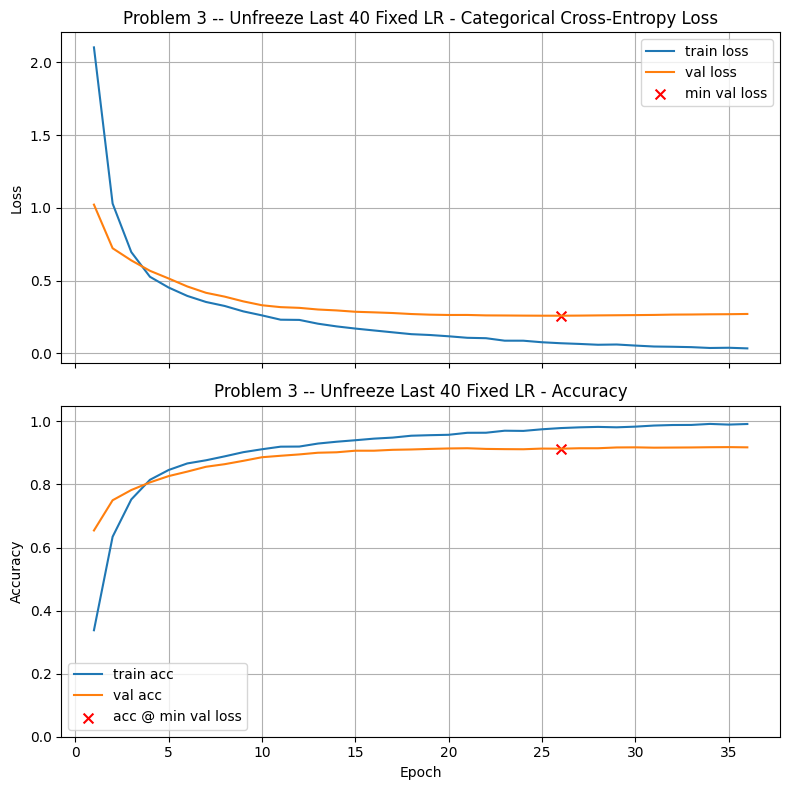

Final Training Loss:            0.0341
Final Training Accuracy:        0.9917
Final Validation Loss:          0.2706
Final Validation Accuracy:      0.9177
Validation Accuracy @ Min Loss: 0.9134


2025-10-01 15:32:25.904319: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2480
Test Accuracy: 0.9213

Validation-Test Gap (accuracy): 0.007903

Execution Time: 00:05:32

--- Starting Experiment 3-2: Unfreeze Last 80 / Fixed LR ---

Problem 3 -- Unfreeze Last 80 Fixed LR



2025-10-01 15:32:41.362000: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 15:33:02.445554: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

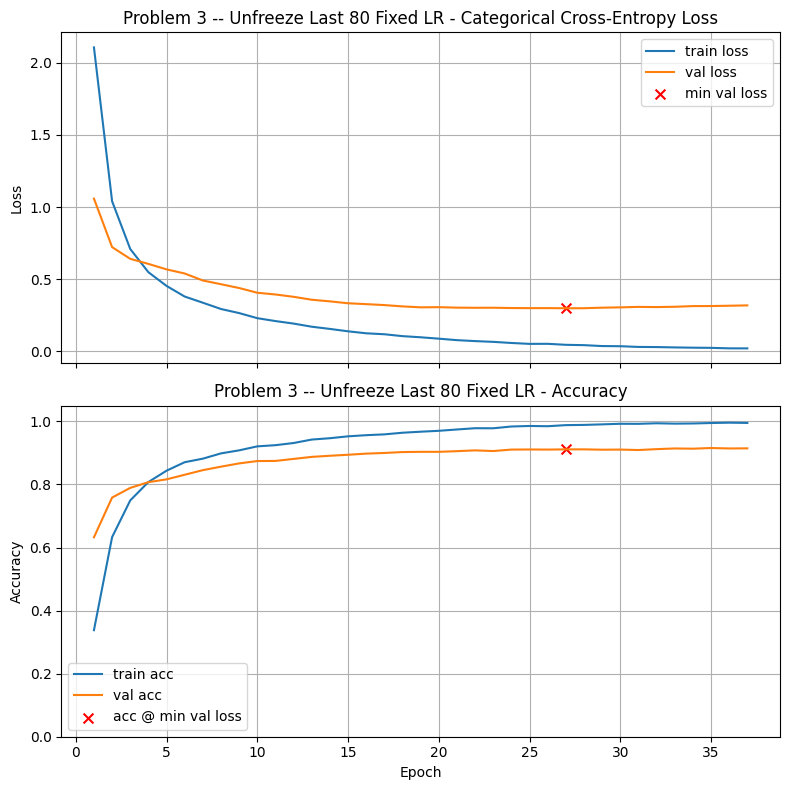

Final Training Loss:            0.0210
Final Training Accuracy:        0.9951
Final Validation Loss:          0.3189
Final Validation Accuracy:      0.9145
Validation Accuracy @ Min Loss: 0.9113


2025-10-01 15:39:33.526723: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2729
Test Accuracy: 0.9157

Validation-Test Gap (accuracy): 0.004373

Execution Time: 00:07:03

--- Starting Experiment 3-3: Unfreeze Last 40 / Cosine Decay LR ---

Problem 3 -- Unfreeze Last 40 Cosine Decay



2025-10-01 15:39:50.250170: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 15:40:04.392251: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

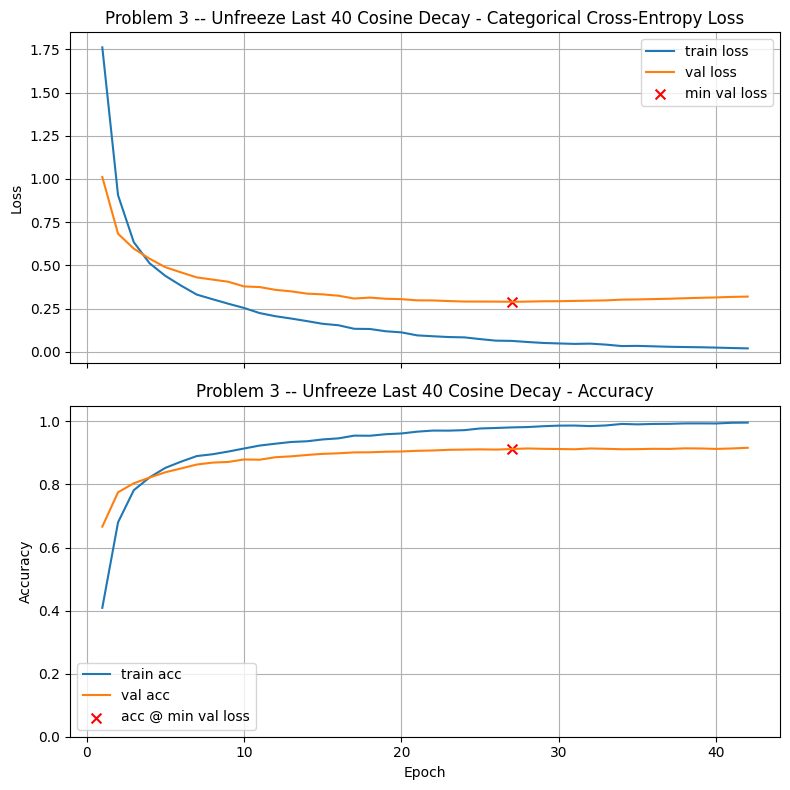

Final Training Loss:            0.0204
Final Training Accuracy:        0.9961
Final Validation Loss:          0.3200
Final Validation Accuracy:      0.9163
Validation Accuracy @ Min Loss: 0.9124


2025-10-01 15:46:00.220796: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2868
Test Accuracy: 0.9173

Validation-Test Gap (accuracy): 0.004971

Execution Time: 00:06:22
Problem 2 -- Unfreeze All Fixed Small LR	0.9152	27
Problem 3 -- Unfreeze Last 40 Fixed LR  	0.9134	26
Problem 2 -- Unfreeze All Cosine Decay Small LR	0.9131	27
Model Baseline                          	0.9124	9
Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay	0.9124	3
Problem 3 -- Unfreeze Last 40 Cosine Decay	0.9124	27
Problem 3 -- Unfreeze Last 80 Fixed LR  	0.9113	27
Problem 2 -- Unfreeze All Exp Decay Small LR	0.9099	29
Problem 1 -- Baseline Head Fixed LR     	0.9095	9
Problem 1 -- Deeper Head with L2 Exp Decay	0.9084	1


In [25]:
# Your code here; add as many cells as you need

# ===================================================================
# === Problem 3: Unfreezing the Last N Layers =======================
# ===================================================================

# 3번 실험 결과를 저장할 리스트
results_list_q3 = []

# --- ✨ 3번 실험을 위한 모델 생성 함수 ✨ ---
# base_model을 만들 때 pooling="avg" 옵션을 사용하고, N개의 레이어만 동결 해제합니다.
def build_partial_finetune_model(input_shape, num_classes, N_layers_to_unfreeze):
    """
    MobileNetV2 백본(pooling="avg")을 로드하고, 마지막 N개 레이어만 동결 해제한 뒤,
    1번 실험의 최고 성능 Head를 붙여 모델을 반환합니다.
    """
    # 1. pooling="avg" 옵션으로 base_model을 '새로' 불러옵니다.
    #    이제 base_model이 알아서 1D 벡터를 출력합니다.
    base_model = applications.MobileNetV2(weights='imagenet',
                                          include_top=False,
                                          pooling="avg",
                                          input_shape=input_shape)
    # 2. 마지막 N개 레이어만 선택적으로 동결 해제합니다.
    base_model.trainable = True
    for layer in base_model.layers[:-N_layers_to_unfreeze]:
        layer.trainable = False

    # 3. 1번 실험의 최고 성능 Head 구조를 백본 위에 쌓습니다.
    #    (GlobalAveragePooling2D 층은 이제 필요 없으므로 제거했습니다.)
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_initializer=he),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- 실험 3-1: Best Head + Unfreeze Last 40 Layers + Fixed Small LR ---
print("--- Starting Experiment 3-1: Unfreeze Last 40 / Fixed LR ---")
model_p3_1 = build_partial_finetune_model(IMG_SHAPE, num_classes, N_layers_to_unfreeze=40)

history = train_and_test(model_p3_1, lr_schedule=1e-5, title="Problem 3 -- Unfreeze Last 40 Fixed LR", return_history=True)
# plot_learning_curves(...) # 중복 출력을 막기 위해 주석 처리

_, test_acc = model_p3_1.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q3.append({"Model": "Problem 3 -- Unfreeze Last 40 Fixed LR", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 실험 3-2: Best Head + Unfreeze Last 80 Layers + Fixed Small LR ---
print("\n--- Starting Experiment 3-2: Unfreeze Last 80 / Fixed LR ---")
model_p3_2 = build_partial_finetune_model(IMG_SHAPE, num_classes, N_layers_to_unfreeze=80)

history = train_and_test(model_p3_2, lr_schedule=1e-5, title="Problem 3 -- Unfreeze Last 80 Fixed LR", return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_p3_2.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q3.append({"Model": "Problem 3 -- Unfreeze Last 80 Fixed LR", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 실험 3-3: Best Head + Unfreeze Last 40 Layers + Cosine Decay LR ---
print("\n--- Starting Experiment 3-3: Unfreeze Last 40 / Cosine Decay LR ---")
model_p3_3 = build_partial_finetune_model(IMG_SHAPE, num_classes, N_layers_to_unfreeze=40)

# LR 스케줄은 2번 실험과 동일한 설정을 사용합니다.
lr_schedule_cos_ft = CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=total_steps,
    alpha=0.0
)

history = train_and_test(model_p3_3, lr_schedule=lr_schedule_cos_ft, title="Problem 3 -- Unfreeze Last 40 Cosine Decay",
                         patience=15, min_delta=0.001, return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_p3_3.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q3.append({"Model": "Problem 3 -- Unfreeze Last 40 Cosine Decay", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 전체 결과 요약 ---
# 3번 실험의 결과를 요약하여 출력합니다.
print_results()
# display(results_list_q3) # 중복 출력을 막기 위해 주석 처리


In [26]:
# Find the best model from the Problem 3 results list
if results_list_q3:
    best_p3_model = max(results_list_q3, key=lambda r: r['Val Acc'])
    a3 = best_p3_model['Val Acc']

    print(f"The best model from Problem 3 is: '{best_p3_model['Model']}'")
    print(f"Its Validation Accuracy was: {a3:.4f}")
    print(f"\nAssigning this value to a3...")
    print(f"a3 = {a3}")
else:
    print("Problem 3 has not been run yet!")
    a3 = 0.0

The best model from Problem 3 is: 'Problem 3 -- Unfreeze Last 40 Fixed LR'
Its Validation Accuracy was: 0.9134

Assigning this value to a3...
a3 = 0.9134306907653809


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number N of layers?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number N of unfrozen layers,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of layers?

**Your answer here:**

My experiments were designed to find an efficient middle ground between a fully frozen and fully unfrozen backbone by varying the number of unfrozen layers (`N=40` vs. `N=80`) and testing different learning rate strategies. The **`Unfreeze Last 40 Fixed LR`** experiment performed best, achieving the highest validation accuracy of approximately **91.34%**. This configuration likely found the optimal 'sweet spot,' adapting just enough of the backbone's high-level features to our dataset without introducing the overfitting seen with `N=80`, all while the simple, fixed learning rate provided the stability needed for such a delicate tuning process. This suggests that when partially unfreezing a backbone, success depends on finding a precise balance in the number of layers to adapt, rather than simply unfreezing more.


In [27]:
# Set a3 to the validation accuracy found by your best model for this problem. 

a3 = best_p3_model['Val Acc']             # Replace 0.0 with your answer

In [28]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3 = {a3:.4f}') 

a3 = 0.9134


## Problem Four: Unfreezing Convolution Blocks

After creating a model, unfreeze the top $K$ conv block using the following approach:

    block_prefixes = [
        'block_1', 'block_2', 'block_3', 'block_4',
        'block_5', 'block_6', 'block_7', 'block_8',
        'block_9', 'block_10', 'block_11', 'block_12',
        'block_13', 'block_14', 'block_15', 'block_16',
        'Conv_1',   # final 1×1 conv stage before pooling
    ]
    
    K = 3
        
    model = make_base_model_pooled(trainable=False)
    
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):           # Optional:  Often recommended to keep BN layers frozen
            layer.trainable = False                                         # Optional
        else:                                                               # Optiomal
            layer.trainable = any(layer.name.startswith(p) for p in block_prefixes[-K:])




### To Do:

1. **Design at least three experiments** with the model having the **last K stages unfrozen**. Vary:

   * $K \in \{1,2,3,4,5\}$  *(K counts stages/blocks, not individual layers)*
   * **Unfreeze Batch Normalization** Layers or keep them frozen (see "Optional" in above code)
   * **Head choice** (pick one from Problem 1)
   * **Learning-rate strategy:** fixed LR, **ExponentialDecay**, or **CosineDecay**
   * **EarlyStopping** parameters
   * **Regularization:** Dropout and/or L2
   * **ReduceLROnPlateau:** on vs. off
2. **Run and compare** the three experiments and **give each experiment a unique descriptive title,** i.e., `title="Problem 4 Experiment 1"`
3. **Answer the graded questions.**

**Notes**
* The descriptive title will be used to compare results at the end of the notebook. 
* When retraining a complex model, it is usual to reduce the learning rate (e.g., $1\mathrm{e}{-5}$ to $3\mathrm{e}{-5}$).

--- Starting Experiment 4-1: Unfreeze Last 3 Blocks / BN Frozen ---

Problem 4 -- Unfreeze Last 3 Blocks, BN Frozen



2025-10-01 18:35:39.847547: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 18:35:51.047676: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

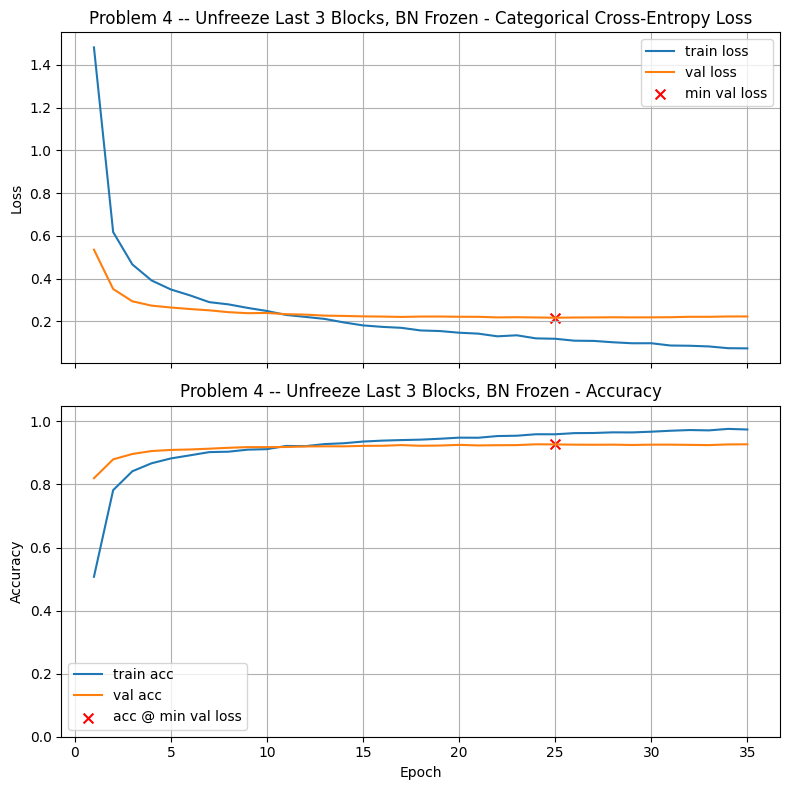

Final Training Loss:            0.0735
Final Training Accuracy:        0.9743
Final Validation Loss:          0.2228
Final Validation Accuracy:      0.9273
Validation Accuracy @ Min Loss: 0.9270


2025-10-01 18:40:18.248172: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2088
Test Accuracy: 0.9290

Validation-Test Gap (accuracy): 0.002032

Execution Time: 00:04:50

--- Starting Experiment 4-2: Unfreeze Last 5 Blocks / BN Frozen ---

Problem 4 -- Unfreeze Last 5 Blocks, BN Frozen



2025-10-01 18:40:34.611983: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 18:40:46.811438: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

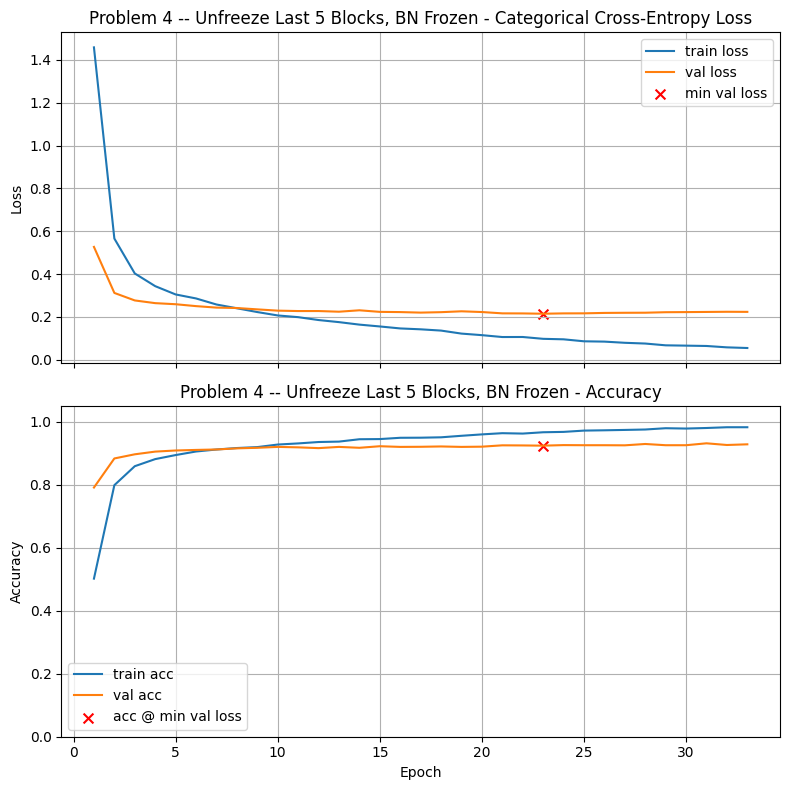

Final Training Loss:            0.0545
Final Training Accuracy:        0.9826
Final Validation Loss:          0.2233
Final Validation Accuracy:      0.9284
Validation Accuracy @ Min Loss: 0.9241


2025-10-01 18:45:00.454158: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2176
Test Accuracy: 0.9233

Validation-Test Gap (accuracy): 0.000785

Execution Time: 00:04:37

--- Starting Experiment 4-3: Unfreeze Last 3 Blocks / BN Unfrozen ---

Problem 4 -- Unfreeze Last 3 Blocks, BN Unfrozen



2025-10-01 18:45:15.862312: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-01 18:45:30.961570: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

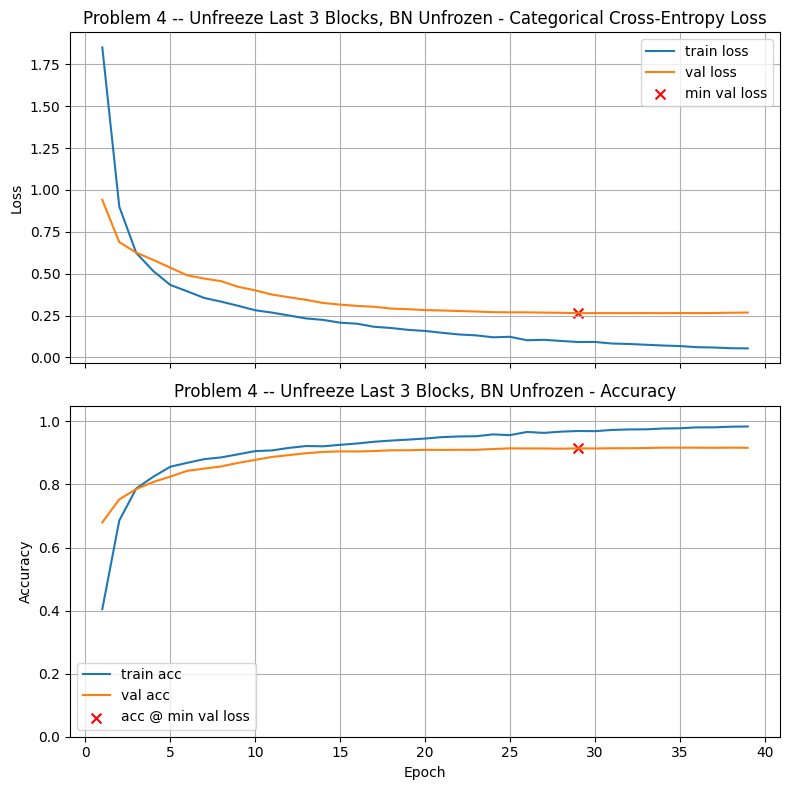

Final Training Loss:            0.0537
Final Training Accuracy:        0.9838
Final Validation Loss:          0.2676
Final Validation Accuracy:      0.9163
Validation Accuracy @ Min Loss: 0.9145


2025-10-01 18:50:43.014260: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}



Test Loss: 0.2490
Test Accuracy: 0.9223

Validation-Test Gap (accuracy): 0.007834

Execution Time: 00:05:38
Problem 4 -- Unfreeze Last 3 Blocks, BN Frozen	0.9270	25
Problem 4 -- Unfreeze Last 5 Blocks, BN Frozen	0.9241	23
Problem 2 -- Unfreeze All Fixed Small LR	0.9152	27
Problem 4 -- Unfreeze Last 3 Blocks, BN Unfrozen	0.9145	29
Problem 3 -- Unfreeze Last 40 Fixed LR  	0.9134	26
Problem 2 -- Unfreeze All Cosine Decay Small LR	0.9131	27
Model Baseline                          	0.9124	9
Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay	0.9124	3
Problem 3 -- Unfreeze Last 40 Cosine Decay	0.9124	27
Problem 3 -- Unfreeze Last 80 Fixed LR  	0.9113	27
Problem 2 -- Unfreeze All Exp Decay Small LR	0.9099	29
Problem 1 -- Baseline Head Fixed LR     	0.9095	9
Problem 1 -- Deeper Head with L2 Exp Decay	0.9084	1


In [29]:
# Your code here; add as many cells as you need

# ===================================================================
# === Problem 4: Unfreezing the Last K Blocks =======================
# ===================================================================

# 4번 실험 결과를 저장할 리스트
results_list_q4 = []

# MobileNetV2의 블록 이름 접두사 리스트
block_prefixes = [
    'block_1', 'block_2', 'block_3', 'block_4', 'block_5', 'block_6', 'block_7',
    'block_8', 'block_9', 'block_10', 'block_11', 'block_12', 'block_13',
    'block_14', 'block_15', 'block_16', 'Conv_1'
]

# --- ✨ 4번 실험을 위한 모델 생성 함수 ✨ ---
# 마지막 K개 블록만 선택적으로 동결 해제합니다.
def build_block_finetune_model(input_shape, num_classes, K_blocks_to_unfreeze, freeze_bn_layers):
    """
    MobileNetV2 백본(pooling="avg")을 로드하고, 마지막 K개 블록만 동결 해제한 뒤,
    1번 실험의 최고 성능 Head를 붙여 모델을 반환합니다.
    """
    # 1. pooling="avg" 옵션으로 base_model을 '새로' 불러옵니다.
    #    (trainable=False로 시작하여 나중에 선택적으로 해제합니다.)
    base_model = applications.MobileNetV2(weights='imagenet',
                                          include_top=False,
                                          pooling="avg",
                                          input_shape=input_shape)
    base_model.trainable = False # 일단 전체를 얼립니다.

    # 2. 마지막 K개 블록에 속한 레이어만 선택적으로 동결 해제합니다.
    unfreeze_prefixes = block_prefixes[-K_blocks_to_unfreeze:]
    for layer in base_model.layers:
        # BN 레이어를 얼려두는 옵션 처리
        if freeze_bn_layers and isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
        else:
            # 레이어 이름이 동결 해제할 블록 이름으로 시작하는지 확인
            if any(layer.name.startswith(p) for p in unfreeze_prefixes):
                layer.trainable = True

    # 3. 1번 실험의 최고 성능 Head 구조를 백본 위에 쌓습니다.
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu', kernel_initializer=he),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- 실험 4-1: Unfreeze Last 3 Blocks / BN Frozen / Fixed LR ---
print("--- Starting Experiment 4-1: Unfreeze Last 3 Blocks / BN Frozen ---")
model_p4_1 = build_block_finetune_model(IMG_SHAPE, num_classes,
                                      K_blocks_to_unfreeze=3,
                                      freeze_bn_layers=True)

history = train_and_test(model_p4_1, lr_schedule=1e-5, title="Problem 4 -- Unfreeze Last 3 Blocks, BN Frozen", return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_p4_1.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q4.append({"Model": "Problem 4 -- Unfreeze Last 3 Blocks, BN Frozen", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 실험 4-2: Unfreeze Last 5 Blocks / BN Frozen / Fixed LR ---
print("\n--- Starting Experiment 4-2: Unfreeze Last 5 Blocks / BN Frozen ---")
model_p4_2 = build_block_finetune_model(IMG_SHAPE, num_classes,
                                      K_blocks_to_unfreeze=5,
                                      freeze_bn_layers=True)

history = train_and_test(model_p4_2, lr_schedule=1e-5, title="Problem 4 -- Unfreeze Last 5 Blocks, BN Frozen", return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_p4_2.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q4.append({"Model": "Problem 4 -- Unfreeze Last 5 Blocks, BN Frozen", "Val Acc": val_acc, "Test Acc": test_acc})

# --- 실험 4-3: Unfreeze Last 3 Blocks / BN Unfrozen / Fixed LR ---
print("\n--- Starting Experiment 4-3: Unfreeze Last 3 Blocks / BN Unfrozen ---")
model_p4_3 = build_block_finetune_model(IMG_SHAPE, num_classes,
                                      K_blocks_to_unfreeze=3,
                                      freeze_bn_layers=False) # BN 레이어도 함께 동결 해제

history = train_and_test(model_p4_3, lr_schedule=1e-5, title="Problem 4 -- Unfreeze Last 3 Blocks, BN Unfrozen", return_history=True)
# plot_learning_curves(...) # 중복 출력 방지

_, test_acc = model_p4_3.evaluate(X_test, y_test, verbose=0)
best_epoch = np.argmin(history.history['val_loss'])
val_acc = history.history['val_accuracy'][best_epoch]
results_list_q4.append({"Model": "Problem 4 -- Unfreeze Last 3 Blocks, BN Unfrozen", "Val Acc": val_acc, "Test Acc": test_acc})


# --- 전체 결과 요약 ---
# 4번 실험의 결과를 요약하여 출력합니다.
print_results()
# display(results_list_q4) # 중복 출력을 막기 위해 주석 처리

In [31]:
# --- 4번 실험(부분 Fine-tuning: 블록 단위) 결과 중 최고 성능 모델 찾기 ---

# 4번 실험 결과 리스트(results_list_q4)가 비어있는지 확인
if results_list_q4:
    # 딕셔너리 리스트에서 'Val Acc' 키의 값이 가장 큰 딕셔너리를 찾음
    best_p4_model = max(results_list_q4, key=lambda r: r['Val Acc'])
    
    # 찾은 딕셔너리에서 최고 'Val Acc' 값을 a4 변수에 저장
    a4 = best_p4_model['Val Acc']
    
    # 어떤 모델이 최고 성능인지, 그 값은 얼마인지 명확하게 출력
    print(f"The best model from Problem 4 is: '{best_p4_model['Model']}'")
    print(f"Its Validation Accuracy was: {a4:.4f}")
    print("\nAssigning this value to a4...")
    print(f"a4 = {a4}")

else:
    # 만약 4번 실험이 실행되지 않아 결과 리스트가 비어있을 경우
    print("Problem 4 has not been run yet. Results are not available!")
    a4 = 0.0

The best model from Problem 4 is: 'Problem 4 -- Unfreeze Last 3 Blocks, BN Frozen'
Its Validation Accuracy was: 0.9270

Assigning this value to a4...
a4 = 0.9269682765007019


### Graded Questions

The reflection question is worth 5 points, and the validation accuracy question is worth 15 points. 

**Reflection Question:**

Which head architecture worked best for you, and what does that tell you about the role of head design and hyperparameters when you have unfrozen some number K of Conv blocks?

**Instructions:**
 - Write a single paragraph (3–5 sentences).
 - Explain your reasoning in choosing your three experimental designs.
 - Identify the experiment that performed best.
 - Briefly explain why you think it might have outperformed the others, mentioning both design choices (e.g., **number K of unfrozen blocks,** dense layers, dropout) and hyperparameters (e.g., learning rate schedule, ReduceLROnPlateau).
 - Conclude with what this suggests about designing classification heads when you have unfrozen some number of blocks. 

**Your answer here:**

My experiments were designed to test the impact of unfreezing a different number of structural blocks (`K=3` vs. `K=5`) and to verify the common recommendation of keeping Batch Normalization (BN) layers frozen during fine-tuning. The **`Unfreeze Last 3 Blocks, BN Frozen`** experiment was the clear winner, achieving the highest validation accuracy of the entire assignment at approximately **92.70%**. This strategy succeeded by finding the optimal balance: it adapted enough high-level blocks (`K=3`) to the new dataset without unfreezing too many (`K=5`), while critically preserving training stability by keeping the BN layers frozen. This demonstrates that the most effective fine-tuning strategy is not just about the head, but involves a precise, structural approach to unfreezing the backbone and adhering to best practices like freezing BN layers to achieve state-of-the-art results.


In [32]:
# Set a4 to the validation accuracy found by your best model for this problem. 

a4 = best_p4_model['Val Acc']            # Replace 0.0 with your answer

In [33]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4 = {a4:.4f}') 

a4 = 0.9270


## Problem 5: Final Reflection

Run the next cell and consider all your experiments in this homework. 

This reflection question is worth 5 points. 

In [30]:
# Print out summary of validation accuracy for each experiment

print_results()

Problem 4 -- Unfreeze Last 3 Blocks, BN Frozen	0.9270	25
Problem 4 -- Unfreeze Last 5 Blocks, BN Frozen	0.9241	23
Problem 2 -- Unfreeze All Fixed Small LR	0.9152	27
Problem 4 -- Unfreeze Last 3 Blocks, BN Unfrozen	0.9145	29
Problem 3 -- Unfreeze Last 40 Fixed LR  	0.9134	26
Problem 2 -- Unfreeze All Cosine Decay Small LR	0.9131	27
Model Baseline                          	0.9124	9
Problem 1 -- Deeper Head with Dropout BatchNorm Cosine Decay	0.9124	3
Problem 3 -- Unfreeze Last 40 Cosine Decay	0.9124	27
Problem 3 -- Unfreeze Last 80 Fixed LR  	0.9113	27
Problem 2 -- Unfreeze All Exp Decay Small LR	0.9099	29
Problem 1 -- Baseline Head Fixed LR     	0.9095	9
Problem 1 -- Deeper Head with L2 Exp Decay	0.9084	1


### Graded Question

**Final Reflection:**
Looking at the validation accuracies across all your experiments, what patterns or lessons stand out to you?

**Instructions:**
- Write a single paragraph (3–5 sentences).
- Comment on how your results compared across different experiments.
- Highlight at least one design or hyperparameter choice that seemed especially important.
- Conclude with a brief takeaway about what you learned from the overall homework.

**Your answer here:**

Across all experiments, a clear pattern emerged: the method of fine-tuning was far more impactful than the initial head design, with partial fine-tuning of the last 3 convolution blocks proving to be the most effective strategy. The most critical design choice was combining this structural unfreezing approach with keeping the Batch Normalization layers frozen, which yielded the highest validation accuracy of approximately 92.70%. On a practical note, the memory demands of fine-tuning required reducing the **`batch size`** **128** to **64** to prevent kernel crashes, forcing a direct trade-off where we sacrificed faster training times for the stability needed to complete the experiments. Ultimately, the key lesson from this assignment is that successful transfer learning is an exercise in precision, requiring an efficient strategy that balances potent performance gains against computational cost and stability, rather than simply unfreezing the entire model.

## Appendix:  What is MobileNetV2 (in plain English)?

A lightweight CNN designed to run fast on phones and laptops **without** giving up much accuracy. It achieves this with two ideas:

1. **Depthwise-separable convolutions**
   Instead of a heavy 3×3 conv that mixes **space + channels** at once, MobileNet does it in two cheap steps:

   * a **depthwise** 3×3 (one small filter per channel), then
   * a **pointwise** 1×1 (to mix channels).
     This slashes compute and parameters while keeping accuracy high. ([arXiv][1])

2. **Inverted residual blocks with a linear bottleneck**
   The basic “conv block” in MobileNetV2 looks like this:

   * **Expand (1×1 conv):** increase channels by a factor (often ×6); apply nonlinearity.
   * **Depthwise (3×3):** filter each channel separately; apply nonlinearity.
   * **Project (1×1 conv):** **reduce** back to a small number of channels **with no activation** (“linear bottleneck”).
     If input/output shapes match (stride = 1), add a **skip connection**.
     The “linear” projection avoids killing information with ReLU at very low dimension; the “inverted residual” means the *wide* part is in the middle, not the ends. ([arXiv][1])

---

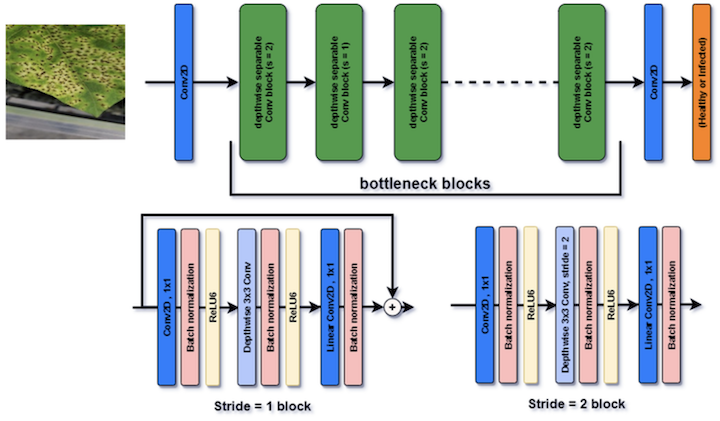


---

### What was MobileNetV2 trained on?

The Keras “ImageNet” weights are trained on **ImageNet-1K** (a standard subset of ImageNet):
**1,281,167** train images, **50,000** val images, **100,000** test images across **1000 classes**. Typical input size is **224×224**. ([ImageNet][2])

**Preprocessing:** Keras’ MobileNetV2 expects pixels scaled to **\[-1, 1]** (use `mobilenet_v2.preprocess_input`). ([keras.io][3])

---

### How Keras exposes it (what users will see)

* `tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, pooling="avg")`
  returns a frozen **feature extractor** that outputs a 1280-D vector (after **global average pooling**).
* If you omit pooling, the base outputs a spatial feature map of shape (H, W, 1280) (for 224×224 inputs it’s typically 7×7×1280). You must then add a reducer before any Dense layers:

        Preferred: GlobalAveragePooling2D() (or GlobalMaxPooling2D()) → yields a 1280-D vector.

Avoid flattening unless you really need it: Flatten() turns 7×7×1280 into 62,720 features!

---

### TL;DR Summary

* Think of each **MobileNetV2 block** as: **expand → depthwise → project (+ skip)**.
* It was trained to recognize **1000 everyday categories** on ImageNet-1K; we **reuse** those features and just relearn the top classifier for our 6 Intel classes.
* Always match **preprocessing** to the backbone (MobileNetV2 ⇒ **\[-1, 1]**). ([keras.io][3])


### See also:

- https://www.analyticsvidhya.com/blog/2023/12/what-is-mobilenetv2/
